Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 141MB/s] 


Dataset Summary -> Train: 75 | Val: 22 | Test: 11

Starting Training...
Epoch 001 | Train Loss: 1.3993 | Val Loss: 1.3724 | LR: 1.00e-04
Epoch 002 | Train Loss: 1.3256 | Val Loss: 1.2763 | LR: 1.00e-04
Epoch 003 | Train Loss: 1.3362 | Val Loss: 1.2936 | LR: 1.00e-04
Epoch 004 | Train Loss: 1.3362 | Val Loss: 1.2917 | LR: 1.00e-04
Epoch 005 | Train Loss: 1.2984 | Val Loss: 1.3287 | LR: 1.00e-04
Epoch 006 | Train Loss: 1.2729 | Val Loss: 1.3139 | LR: 1.00e-04
Epoch 007 | Train Loss: 1.2794 | Val Loss: 1.3217 | LR: 1.00e-04
Epoch 008 | Train Loss: 1.3220 | Val Loss: 1.3242 | LR: 5.00e-05
Epoch 009 | Train Loss: 1.1905 | Val Loss: 1.3304 | LR: 5.00e-05
Epoch 010 | Train Loss: 1.1771 | Val Loss: 1.3179 | LR: 5.00e-05
Epoch 011 | Train Loss: 1.2152 | Val Loss: 1.3087 | LR: 5.00e-05
Epoch 012 | Train Loss: 1.1597 | Val Loss: 1.3506 | LR: 5.00e-05
Epoch 013 | Train Loss: 1.1956 | Val Loss: 1.3316 | LR: 5.00e-05
Epoch 014 | Train Loss: 1.1263 | Val Loss: 1.3514 | LR: 2.50e-05
Epoch 015 | Train 

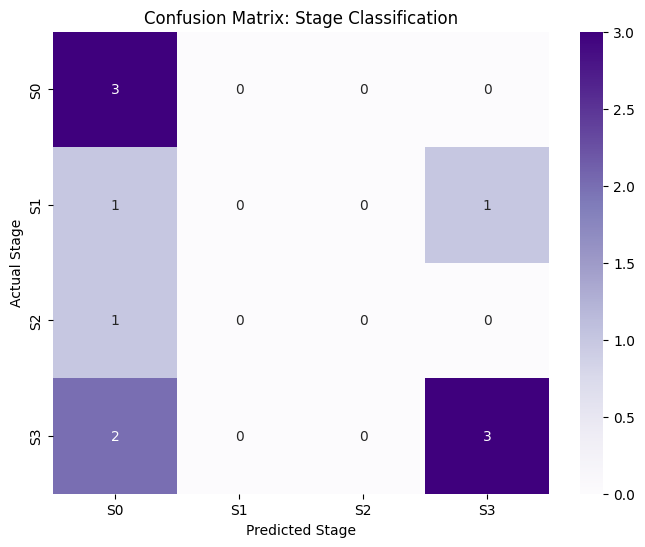

              precision    recall  f1-score   support

          S0       0.43      1.00      0.60         3
          S1       0.00      0.00      0.00         2
          S2       0.00      0.00      0.00         1
          S3       0.75      0.60      0.67         5

    accuracy                           0.55        11
   macro avg       0.29      0.40      0.32        11
weighted avg       0.46      0.55      0.47        11



In [11]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# --- 1. CONFIGURATION ---
DATA_PATH = '/kaggle/input/extracted-scans-categorizes0-s1-s2-s3/extracted_scans'
CLASSES = ['S0', 'S1', 'S2', 'S3']
MAX_SEQ_LENGTH = 8   
BATCH_SIZE = 4
EPOCHS = 100         
PATIENCE = 15        
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. DATASET CLASS ---
class PancreasDataset(Dataset):
    def __init__(self, paths, labels, transform=None, is_train=True):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        self.is_train = is_train

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        label = self.labels[idx]
        img_names = sorted([f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        
        if self.is_train and len(img_names) > MAX_SEQ_LENGTH:
            selected = sorted(random.sample(img_names, MAX_SEQ_LENGTH))
        elif len(img_names) > MAX_SEQ_LENGTH:
            indices = np.linspace(0, len(img_names)-1, MAX_SEQ_LENGTH, dtype=int)
            selected = [img_names[i] for i in indices]
        else:
            selected = img_names

        sequence = []
        for name in selected:
            img = Image.open(os.path.join(path, name)).convert('RGB')
            if self.transform: img = self.transform(img)
            sequence.append(img)
            
        while len(sequence) < MAX_SEQ_LENGTH:
            padding = torch.zeros_like(sequence[0]) if sequence else torch.zeros(3, 224, 224)
            sequence.append(padding)
            
        return torch.stack(sequence), label

# --- 3. MODEL: Frozen EfficientNet + Simple Transformer ---
class PancreasTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        # Load pre-trained EfficientNet
        backbone = models.efficientnet_b0(weights='IMAGENET1K_V1')
        
        # FREEZE BACKBONE: Prevents overfitting on small sample sizes
        for param in backbone.parameters():
            param.requires_grad = False
            
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-1])
        
        # Simplified Transformer
        encoder_layer = nn.TransformerEncoderLayer(d_model=1280, nhead=4, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)
        
        self.classifier = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 4)
        )

    def forward(self, x):
        batch, seq, c, h, w = x.shape
        x = x.view(batch * seq, c, h, w)
        features = self.feature_extractor(x).view(batch, seq, -1)
        x = self.transformer(features)
        x = torch.mean(x, dim=1) 
        return self.classifier(x)

# --- 4. DATA PREPARATION (MODIFIED SPLIT RATIO) ---
all_paths, all_labels = [], []
for i, cls in enumerate(CLASSES):
    cls_dir = os.path.join(DATA_PATH, cls)
    if os.path.exists(cls_dir):
        folders = os.listdir(cls_dir)
        for p_folder in folders:
            all_paths.append(os.path.join(cls_dir, p_folder))
            all_labels.append(i)

# First split: 70% Train, 30% Temporary (Val + Test)
train_p, temp_p, train_l, temp_l = train_test_split(
    all_paths, all_labels, test_size=0.30, stratify=all_labels, random_state=42
)

# Second split: From the 30% temp, take 2/3 for Val (20% of total) and 1/3 for Test (10% of total)
val_p, test_p, val_l, test_l = train_test_split(
    temp_p, temp_l, test_size=0.333, stratify=temp_l, random_state=42
)

# Training Augmentation
train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Validation/Test Transforms
val_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_loader = DataLoader(PancreasDataset(train_p, train_l, train_tfms, True), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(PancreasDataset(val_p, val_l, val_tfms, False), batch_size=BATCH_SIZE)
test_loader = DataLoader(PancreasDataset(test_p, test_l, val_tfms, False), batch_size=BATCH_SIZE)

# --- 5. TRAINING LOOP ---
model = PancreasTransformer().to(DEVICE)

# Weighted Loss to handle class imbalance
class_weights = torch.tensor([2.0, 2.0, 2.0, 1.0]).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Scheduler for PyTorch 2.x compatibility
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

best_val_loss = float('inf')
no_improve = 0

print(f"Dataset Summary -> Train: {len(train_p)} | Val: {len(val_p)} | Test: {len(test_p)}")
print("\nStarting Training...")

for epoch in range(EPOCHS):
    model.train()
    t_loss = 0
    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(model(imgs), lbls)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
    
    model.eval()
    v_loss = 0
    with torch.no_grad():
        for imgs, lbls in val_loader:
            v_loss += criterion(model(imgs.to(DEVICE)), lbls.to(DEVICE)).item()
    
    avg_v_loss = v_loss / len(val_loader)
    avg_t_loss = t_loss / len(train_loader)
    
    scheduler.step(avg_v_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f"Epoch {epoch+1:03d} | Train Loss: {avg_t_loss:.4f} | Val Loss: {avg_v_loss:.4f} | LR: {current_lr:.2e}")

    if avg_v_loss < best_val_loss:
        best_val_loss = avg_v_loss
        torch.save(model.state_dict(), 'best_pancreas_model.pth')
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print(f"Early Stopping! Best Val Loss: {best_val_loss:.4f}")
            break

# --- 6. FINAL EVALUATION ---
def final_evaluate():
    if os.path.exists('best_pancreas_model.pth'):
        model.load_state_dict(torch.load('best_pancreas_model.pth'))
    model.eval()
    all_preds, all_true = [], []
    with torch.no_grad():
        for imgs, lbls in test_loader:
            out = model(imgs.to(DEVICE))
            all_preds.extend(out.argmax(1).cpu().numpy())
            all_true.extend(lbls.numpy())

    cm = confusion_matrix(all_true, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES, cmap='Purples')
    plt.title("Confusion Matrix: Stage Classification")
    plt.ylabel('Actual Stage')
    plt.xlabel('Predicted Stage')
    plt.show()
    
    print(classification_report(all_true, all_preds, target_names=CLASSES, zero_division=0))

final_evaluate()

Dataset Summary -> Train: 75 | Val: 22 | Test: 11
Early Stopping! Best Val Loss: 1.3714363773663838
              precision    recall  f1-score   support

          S0       0.33      1.00      0.50         3
          S1       0.00      0.00      0.00         2
          S2       0.00      0.00      0.00         1
          S3       0.50      0.20      0.29         5

    accuracy                           0.36        11
   macro avg       0.21      0.30      0.20        11
weighted avg       0.32      0.36      0.27        11



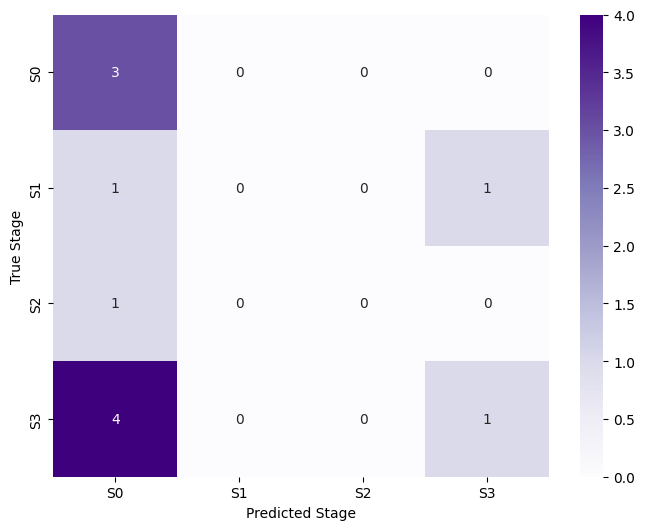

In [14]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# --- 1. CONFIGURATION ---
DATA_PATH = '/kaggle/input/extracted-scans-categorizes0-s1-s2-s3/extracted_scans'
CLASSES = ['S0', 'S1', 'S2', 'S3']
MAX_SEQ_LENGTH = 8   
BATCH_SIZE = 4
EPOCHS = 100         
PATIENCE = 15        
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. DATASET CLASS ---
class PancreasDataset(Dataset):
    def __init__(self, paths, labels, transform=None, is_train=True):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        self.is_train = is_train

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        label = self.labels[idx]
        img_names = sorted([f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        
        if self.is_train and len(img_names) > MAX_SEQ_LENGTH:
            selected = sorted(random.sample(img_names, MAX_SEQ_LENGTH))
        elif len(img_names) > MAX_SEQ_LENGTH:
            indices = np.linspace(0, len(img_names)-1, MAX_SEQ_LENGTH, dtype=int)
            selected = [img_names[i] for i in indices]
        else:
            selected = img_names

        sequence = []
        for name in selected:
            img = Image.open(os.path.join(path, name)).convert('RGB')
            if self.transform: img = self.transform(img)
            sequence.append(img)
            
        while len(sequence) < MAX_SEQ_LENGTH:
            padding = torch.zeros_like(sequence[0]) if sequence else torch.zeros(3, 224, 224)
            sequence.append(padding)
            
        return torch.stack(sequence), label

# --- 3. MODEL: Frozen EfficientNet + Simple Transformer ---

class PancreasTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        # Load pre-trained EfficientNet
        backbone = models.efficientnet_b0(weights='IMAGENET1K_V1')
        
        # Freeze backbone to prevent overfitting on small N=108
        for param in backbone.parameters():
            param.requires_grad = False
            
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-1])
        
        # Transformer to process the 8-slice sequence
        encoder_layer = nn.TransformerEncoderLayer(d_model=1280, nhead=4, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)
        
        self.classifier = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 4)
        )

    def forward(self, x):
        batch, seq, c, h, w = x.shape
        x = x.view(batch * seq, c, h, w)
        features = self.feature_extractor(x).view(batch, seq, -1)
        x = self.transformer(features)
        x = torch.mean(x, dim=1) 
        return self.classifier(x)

# --- 4. DATA PREPARATION (70% Train, 20% Val, 10% Test) ---
all_paths, all_labels = [], []
for i, cls in enumerate(CLASSES):
    cls_dir = os.path.join(DATA_PATH, cls)
    if os.path.exists(cls_dir):
        folders = os.listdir(cls_dir)
        for p_folder in folders:
            all_paths.append(os.path.join(cls_dir, p_folder))
            all_labels.append(i)

# First split: 70% Train, 30% Temporary
train_p, temp_p, train_l, temp_l = train_test_split(
    all_paths, all_labels, test_size=0.30, stratify=all_labels, random_state=42
)

# Second split: 2/3 of temp for Val (20% total), 1/3 of temp for Test (10% total)
val_p, test_p, val_l, test_l = train_test_split(
    temp_p, temp_l, test_size=0.333, stratify=temp_l, random_state=42
)

# Augmentation for Training
train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_loader = DataLoader(PancreasDataset(train_p, train_l, train_tfms, True), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(PancreasDataset(val_p, val_l, val_tfms, False), batch_size=BATCH_SIZE)
test_loader = DataLoader(PancreasDataset(test_p, test_l, val_tfms, False), batch_size=BATCH_SIZE)

# --- 5. TRAINING LOOP ---
model = PancreasTransformer().to(DEVICE)

# Adjusted weights to force the model to pay attention to minority classes S0, S1, S2
class_weights = torch.tensor([2.5, 2.5, 2.5, 1.0]).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

best_val_loss = float('inf')
no_improve = 0

print(f"Dataset Summary -> Train: {len(train_p)} | Val: {len(val_p)} | Test: {len(test_p)}")

for epoch in range(EPOCHS):
    model.train()
    t_loss = 0
    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(model(imgs), lbls)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
    
    model.eval()
    v_loss = 0
    with torch.no_grad():
        for imgs, lbls in val_loader:
            v_loss += criterion(model(imgs.to(DEVICE)), lbls.to(DEVICE)).item()
    
    avg_v_loss = v_loss / len(val_loader)
    scheduler.step(avg_v_loss)
    
    if avg_v_loss < best_val_loss:
        best_val_loss = avg_v_loss
        torch.save(model.state_dict(), 'best_pancreas_model.pth')
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print(f"Early Stopping! Best Val Loss: {best_val_loss}")
            break

# --- 6. FINAL EVALUATION ---

def final_evaluate():
    if os.path.exists('best_pancreas_model.pth'):
        model.load_state_dict(torch.load('best_pancreas_model.pth'))
    model.eval()
    all_preds, all_true = [], []
    with torch.no_grad():
        for imgs, lbls in test_loader:
            out = model(imgs.to(DEVICE))
            all_preds.extend(out.argmax(1).cpu().numpy())
            all_true.extend(lbls.numpy())

    print(classification_report(all_true, all_preds, target_names=CLASSES, zero_division=0))
    cm = confusion_matrix(all_true, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES, cmap='Purples')
    plt.xlabel('Predicted Stage')
    plt.ylabel('True Stage')
    plt.show()

final_evaluate()

Total Samples: 108 | Folds: 5

--- FOLD 1 ---
Fold 1 Best Val Loss: 1.3773

--- FOLD 2 ---
Fold 2 Best Val Loss: 1.3111

--- FOLD 3 ---
Fold 3 Best Val Loss: 1.3111

--- FOLD 4 ---
Fold 4 Best Val Loss: 1.3680

--- FOLD 5 ---
Fold 5 Best Val Loss: 1.4378

Calculating Ensemble Predictions...


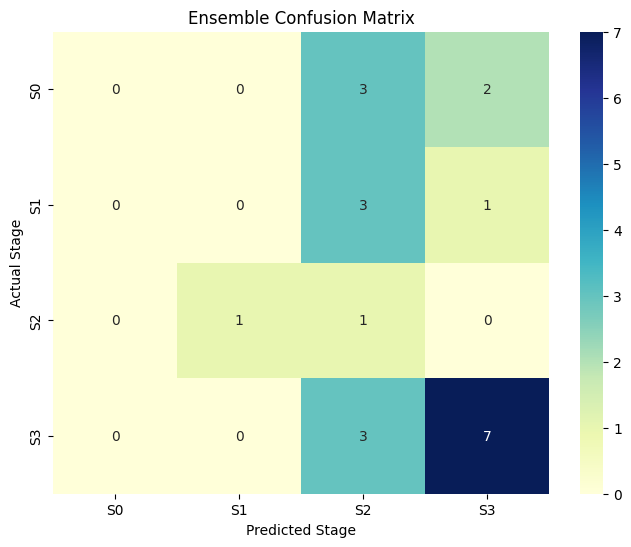

              precision    recall  f1-score   support

          S0       0.00      0.00      0.00         5
          S1       0.00      0.00      0.00         4
          S2       0.10      0.50      0.17         2
          S3       0.70      0.70      0.70        10

    accuracy                           0.38        21
   macro avg       0.20      0.30      0.22        21
weighted avg       0.34      0.38      0.35        21



In [15]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

# --- 1. CONFIGURATION ---
DATA_PATH = '/kaggle/input/extracted-scans-categorizes0-s1-s2-s3/extracted_scans'
CLASSES = ['S0', 'S1', 'S2', 'S3']
MAX_SEQ_LENGTH = 8   
BATCH_SIZE = 4
EPOCHS = 100         
PATIENCE = 15        
FOLDS = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. DATASET CLASS ---
class PancreasDataset(Dataset):
    def __init__(self, paths, labels, transform=None, is_train=True):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        self.is_train = is_train

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        label = self.labels[idx]
        img_names = sorted([f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        
        if self.is_train and len(img_names) > MAX_SEQ_LENGTH:
            selected = sorted(random.sample(img_names, MAX_SEQ_LENGTH))
        elif len(img_names) > MAX_SEQ_LENGTH:
            indices = np.linspace(0, len(img_names)-1, MAX_SEQ_LENGTH, dtype=int)
            selected = [img_names[i] for i in indices]
        else:
            selected = img_names

        sequence = []
        for name in selected:
            img = Image.open(os.path.join(path, name)).convert('RGB')
            if self.transform: img = self.transform(img)
            sequence.append(img)
            
        while len(sequence) < MAX_SEQ_LENGTH:
            padding = torch.zeros_like(sequence[0]) if sequence else torch.zeros(3, 224, 224)
            sequence.append(padding)
            
        return torch.stack(sequence), label

# --- 3. MODEL: Selective Unfreezing + Transformer ---
class PancreasTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = models.efficientnet_b0(weights='IMAGENET1K_V1')
        
        # Freeze everything initially
        for param in backbone.parameters():
            param.requires_grad = False
            
        # Unfreeze final blocks to learn medical-specific textures
        for name, param in backbone.named_parameters():
            if "blocks.6" in name or "blocks.7" in name or "features.8" in name:
                param.requires_grad = True
                
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-1])
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=1280, nhead=4, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)
        
        self.classifier = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 4)
        )

    def forward(self, x):
        batch, seq, c, h, w = x.shape
        x = x.view(batch * seq, c, h, w)
        features = self.feature_extractor(x).view(batch, seq, -1)
        x = self.transformer(features)
        x = torch.mean(x, dim=1) 
        return self.classifier(x)

# --- 4. DATA PREPARATION ---
all_paths, all_labels = [], []
for i, cls in enumerate(CLASSES):
    cls_dir = os.path.join(DATA_PATH, cls)
    if os.path.exists(cls_dir):
        for p_folder in os.listdir(cls_dir):
            all_paths.append(os.path.join(cls_dir, p_folder))
            all_labels.append(i)

all_paths = np.array(all_paths)
all_labels = np.array(all_labels)

# Augmentations
train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# --- 5. K-FOLD TRAINING LOOP ---
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
fold_results = []

print(f"Total Samples: {len(all_paths)} | Folds: {FOLDS}")

for fold, (train_idx, val_idx) in enumerate(skf.split(all_paths, all_labels)):
    print(f"\n--- FOLD {fold+1} ---")
    
    train_p, val_p = all_paths[train_idx], all_paths[val_idx]
    train_l, val_l = all_labels[train_idx], all_labels[val_idx]
    
    train_loader = DataLoader(PancreasDataset(train_p, train_l, train_tfms, True), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(PancreasDataset(val_p, val_l, val_tfms, False), batch_size=BATCH_SIZE)
    
    model = PancreasTransformer().to(DEVICE)
    
    # Weights prioritize S1 and S2 specifically
    class_weights = torch.tensor([1.2, 2.5, 4.0, 1.0]).to(DEVICE)
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
    optimizer = optim.Adam(model.parameters(), lr=5e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    best_val_loss = float('inf')
    no_improve = 0
    
    for epoch in range(EPOCHS):
        model.train()
        t_loss = 0
        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model(imgs), lbls)
            loss.backward()
            optimizer.step()
            t_loss += loss.item()
        
        model.eval()
        v_loss = 0
        with torch.no_grad():
            for imgs, lbls in val_loader:
                v_loss += criterion(model(imgs.to(DEVICE)), lbls.to(DEVICE)).item()
        
        avg_v_loss = v_loss / len(val_loader)
        scheduler.step(avg_v_loss)
        
        if avg_v_loss < best_val_loss:
            best_val_loss = avg_v_loss
            torch.save(model.state_dict(), f'best_model_fold_{fold+1}.pth')
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= PATIENCE: break

    fold_results.append(best_val_loss)
    print(f"Fold {fold+1} Best Val Loss: {best_val_loss:.4f}")

# --- 6. ENSEMBLE EVALUATION ---
# --- 6. FINAL ENSEMBLE EVALUATION & INFERENCE ---

def final_ensemble_evaluate(num_folds=5):
    # Using the last fold's data as the evaluation set
    eval_dataset = PancreasDataset(val_p, val_l, val_tfms, False)
    eval_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    all_fold_probs = []
    true_labels = []
    
    print("\nCalculating Ensemble Predictions...")
    
    for fold in range(1, num_folds + 1):
        model_path = f'best_model_fold_{fold}.pth'
        if not os.path.exists(model_path): continue
            
        model = PancreasTransformer().to(DEVICE)
        model.load_state_dict(torch.load(model_path))
        model.eval()
        
        fold_probs = []
        batch_labels = []
        
        with torch.no_grad():
            for imgs, lbls in eval_loader:
                out = model(imgs.to(DEVICE))
                fold_probs.append(torch.softmax(out, dim=1).cpu().numpy())
                if fold == 1: # Capture labels once
                    batch_labels.extend(lbls.numpy())
        
        all_fold_probs.append(np.concatenate(fold_probs))
        if fold == 1: true_labels = np.array(batch_labels)

    # Soft Voting: Average probabilities across all folds
    avg_probs = np.mean(all_fold_probs, axis=0)
    final_preds = np.argmax(avg_probs, axis=1)

    # Check lengths before plotting
    if len(true_labels) == len(final_preds):
        cm = confusion_matrix(true_labels, final_preds)
        plt.figure(figsize=(8,6))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES, cmap='YlGnBu')
        plt.title("Ensemble Confusion Matrix")
        plt.ylabel('Actual Stage')
        plt.xlabel('Predicted Stage')
        plt.show()
        print(classification_report(true_labels, final_preds, target_names=CLASSES, zero_division=0))
    else:
        print(f"Error: Sample mismatch. True: {len(true_labels)}, Preds: {len(final_preds)}")

def predict_new_patient(patient_path):
    """Predicts the stage for a single patient folder using the 5-fold ensemble."""
    model_dir = '.'
    img_names = sorted([f for f in os.listdir(patient_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    
    # Sequence preparation
    if len(img_names) > MAX_SEQ_LENGTH:
        indices = np.linspace(0, len(img_names)-1, MAX_SEQ_LENGTH, dtype=int)
        selected = [img_names[i] for i in indices]
    else:
        selected = img_names

    sequence = []
    for name in selected:
        img = Image.open(os.path.join(patient_path, name)).convert('RGB')
        sequence.append(val_tfms(img))
    
    while len(sequence) < MAX_SEQ_LENGTH:
        sequence.append(torch.zeros_like(sequence[0]))
    
    input_tensor = torch.stack(sequence).unsqueeze(0).to(DEVICE)

    # Ensemble logic
    ensemble_probs = []
    for fold in range(1, FOLDS + 1):
        model = PancreasTransformer().to(DEVICE)
        model.load_state_dict(torch.load(f'best_model_fold_{fold}.pth'))
        model.eval()
        with torch.no_grad():
            output = model(input_tensor)
            ensemble_probs.append(torch.softmax(output, dim=1).cpu().numpy())

    final_probs = np.mean(ensemble_probs, axis=0)[0]
    pred_idx = np.argmax(final_probs)
    
    print(f"\nResult for {os.path.basename(patient_path)}:")
    print(f"Prediction: {CLASSES[pred_idx]} ({final_probs[pred_idx]*100:.1f}% confidence)")
    return CLASSES[pred_idx]

# --- RUN EVALUATION ---
final_ensemble_evaluate()


--- TRAINING FOLD 1 ---

--- TRAINING FOLD 2 ---

--- TRAINING FOLD 3 ---

--- TRAINING FOLD 4 ---

--- TRAINING FOLD 5 ---

--- Consensus Agreement Analysis ---
When 1/5 models agree: Accuracy is 50.0% (2 samples)
When 3/5 models agree: Accuracy is 33.3% (9 samples)
When 4/5 models agree: Accuracy is 71.4% (7 samples)
When 5/5 models agree: Accuracy is 66.7% (3 samples)


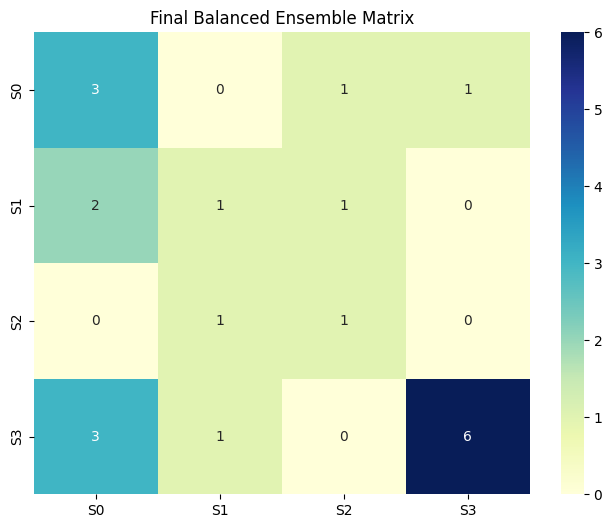

              precision    recall  f1-score   support

          S0       0.38      0.60      0.46         5
          S1       0.33      0.25      0.29         4
          S2       0.33      0.50      0.40         2
          S3       0.86      0.60      0.71        10

    accuracy                           0.52        21
   macro avg       0.47      0.49      0.46        21
weighted avg       0.59      0.52      0.54        21



In [16]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

# --- 1. CONFIGURATION ---
DATA_PATH = '/kaggle/input/extracted-scans-categorizes0-s1-s2-s3/extracted_scans'
CLASSES = ['S0', 'S1', 'S2', 'S3']
MAX_SEQ_LENGTH = 8   
BATCH_SIZE = 4
EPOCHS = 100         
PATIENCE = 15        
FOLDS = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. DATASET CLASS ---
class PancreasDataset(Dataset):
    def __init__(self, paths, labels, transform=None, is_train=True):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        self.is_train = is_train

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        label = self.labels[idx]
        img_names = sorted([f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        
        if self.is_train and len(img_names) > MAX_SEQ_LENGTH:
            selected = sorted(random.sample(img_names, MAX_SEQ_LENGTH))
        elif len(img_names) > MAX_SEQ_LENGTH:
            indices = np.linspace(0, len(img_names)-1, MAX_SEQ_LENGTH, dtype=int)
            selected = [img_names[i] for i in indices]
        else:
            selected = img_names

        sequence = []
        for name in selected:
            img = Image.open(os.path.join(path, name)).convert('RGB')
            if self.transform: img = self.transform(img)
            sequence.append(img)
            
        while len(sequence) < MAX_SEQ_LENGTH:
            padding = torch.zeros_like(sequence[0]) if sequence else torch.zeros(3, 224, 224)
            sequence.append(padding)
            
        return torch.stack(sequence), label

# --- 3. MODEL: Fine-Tuned Backbone + Transformer ---
class PancreasTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = models.efficientnet_b0(weights='IMAGENET1K_V1')
        
        # Freeze early layers
        for param in backbone.parameters():
            param.requires_grad = False
            
        # Unfreeze final blocks to distinguish medical textures
        for name, param in backbone.named_parameters():
            if "blocks.6" in name or "blocks.7" in name or "features.8" in name:
                param.requires_grad = True
                
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-1])
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=1280, nhead=4, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)
        
        self.classifier = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 4)
        )

    def forward(self, x):
        batch, seq, c, h, w = x.shape
        x = x.view(batch * seq, c, h, w)
        features = self.feature_extractor(x).view(batch, seq, -1)
        x = self.transformer(features)
        x = torch.mean(x, dim=1) 
        return self.classifier(x)

# --- 4. DATA PREPARATION ---
all_paths, all_labels = [], []
for i, cls in enumerate(CLASSES):
    cls_dir = os.path.join(DATA_PATH, cls)
    if os.path.exists(cls_dir):
        for p_folder in os.listdir(cls_dir):
            all_paths.append(os.path.join(cls_dir, p_folder))
            all_labels.append(i)

all_paths = np.array(all_paths)
all_labels = np.array(all_labels)

train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# --- 5. TRAINING WITH BALANCED WEIGHTS ---
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(all_paths, all_labels)):
    print(f"\n--- TRAINING FOLD {fold+1} ---")
    
    train_loader = DataLoader(PancreasDataset(all_paths[train_idx], all_labels[train_idx], train_tfms), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(PancreasDataset(all_paths[val_idx], all_labels[val_idx], val_tfms, False), batch_size=BATCH_SIZE)
    
    model = PancreasTransformer().to(DEVICE)
    
    # Balanced "Goldilocks" weights
    class_weights = torch.tensor([1.8, 2.5, 3.0, 1.0]).to(DEVICE)
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.15)
    
    optimizer = optim.Adam(model.parameters(), lr=5e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    best_loss = float('inf')
    no_improve = 0
    
    for epoch in range(EPOCHS):
        model.train()
        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model(imgs), lbls)
            loss.backward()
            optimizer.step()
        
        model.eval()
        v_loss = 0
        with torch.no_grad():
            for imgs, lbls in val_loader:
                v_loss += criterion(model(imgs.to(DEVICE)), lbls.to(DEVICE)).item()
        
        avg_v_loss = v_loss / len(val_loader)
        scheduler.step(avg_v_loss)
        
        if avg_v_loss < best_loss:
            best_loss = avg_v_loss
            torch.save(model.state_dict(), f'best_model_fold_{fold+1}.pth')
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= PATIENCE: break

# --- 6. ENSEMBLE EVALUATION & AGREEMENT ANALYSIS ---
def ensemble_evaluate_and_analyze(val_idx):
    test_loader = DataLoader(PancreasDataset(all_paths[val_idx], all_labels[val_idx], val_tfms, False), batch_size=1)
    
    all_fold_preds = []
    all_fold_probs = []
    true_labels = []

    for fold in range(1, FOLDS + 1):
        model = PancreasTransformer().to(DEVICE)
        model.load_state_dict(torch.load(f'best_model_fold_{fold}.pth'))
        model.eval()
        
        fold_probs = []
        fold_preds = []
        with torch.no_grad():
            for imgs, lbls in test_loader:
                out = model(imgs.to(DEVICE))
                probs = torch.softmax(out, dim=1).cpu().numpy()
                fold_probs.append(probs)
                fold_preds.append(np.argmax(probs))
                if fold == 1: true_labels.append(lbls.item())
        
        all_fold_probs.append(np.array(fold_probs).squeeze())
        all_fold_preds.append(np.array(fold_preds))

    # Calculate Consensus
    avg_probs = np.mean(all_fold_probs, axis=0)
    final_preds = np.argmax(avg_probs, axis=1)
    
    # Model Agreement Logic
    all_fold_preds = np.array(all_fold_preds) # Shape: (5, num_samples)
    agreements = []
    for i in range(len(final_preds)):
        count = np.sum(all_fold_preds[:, i] == final_preds[i])
        agreements.append(count)

    # Visualize Consensus Accuracy
    print("\n--- Consensus Agreement Analysis ---")
    for i in range(1, FOLDS + 1):
        idx = [j for j, count in enumerate(agreements) if count == i]
        if not idx: continue
        correct = np.sum(np.array(final_preds)[idx] == np.array(true_labels)[idx])
        print(f"When {i}/{FOLDS} models agree: Accuracy is {correct/len(idx)*100:.1f}% ({len(idx)} samples)")

    cm = confusion_matrix(true_labels, final_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, xticklabels=CLASSES, yticklabels=CLASSES, cmap='YlGnBu')
    plt.title("Final Balanced Ensemble Matrix")
    plt.show()
    print(classification_report(true_labels, final_preds, target_names=CLASSES, zero_division=0))

# Run analysis on the last fold split
ensemble_evaluate_and_analyze(val_idx)

# Test-Time Augmentation (TTA)
## This is a "cheat code" for better results without re-training the model.

## How it works: When you predict a new patient, you don't just show the model the images once. You show it the images 5 times (flipped, slightly rotated, slightly zoomed) and average the results.

## Why it works: If a patient is a "borderline" S1/S2 case, seeing it from a slightly different angle often helps the ensemble reach a more stable consensus.

Running Ensemble with 5 TTA steps...


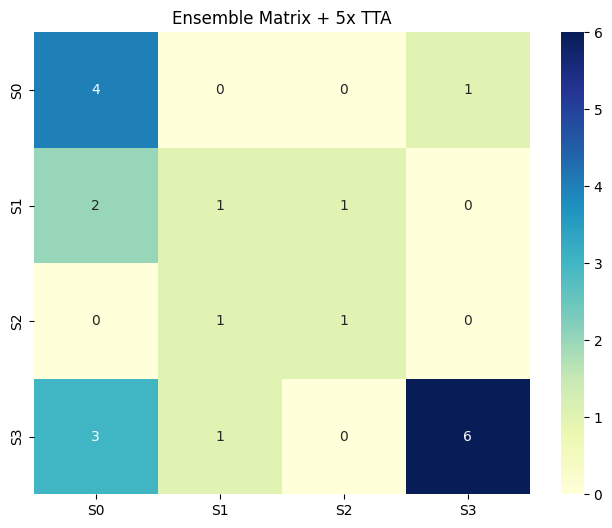

              precision    recall  f1-score   support

          S0       0.44      0.80      0.57         5
          S1       0.33      0.25      0.29         4
          S2       0.50      0.50      0.50         2
          S3       0.86      0.60      0.71        10

    accuracy                           0.57        21
   macro avg       0.53      0.54      0.52        21
weighted avg       0.63      0.57      0.57        21



In [17]:
def ensemble_evaluate_with_tta(val_idx, num_tta=5):
    # Use batch_size=1 to handle TTA easily
    test_loader = DataLoader(PancreasDataset(all_paths[val_idx], all_labels[val_idx], val_tfms, False), batch_size=1)
    
    # Define TTA transforms (slight variations)
    tta_transforms = [
        lambda x: x,  # Original
        lambda x: torch.flip(x, dims=[-1]),  # Horizontal Flip
        lambda x: torch.rot90(x, 1, [-2, -1]), # 90 deg rotation
        lambda x: torch.flip(x, dims=[-2]),  # Vertical Flip
        lambda x: torch.rot90(x, 2, [-2, -1]), # 180 deg rotation
    ]

    all_true = []
    final_ensemble_probs = []

    print(f"Running Ensemble with {num_tta} TTA steps...")

    for imgs, lbls in test_loader:
        all_true.append(lbls.item())
        patient_probs = []
        
        # Loop through each model in the ensemble
        for fold in range(1, FOLDS + 1):
            model = PancreasTransformer().to(DEVICE)
            model.load_state_dict(torch.load(f'best_model_fold_{fold}.pth'))
            model.eval()
            
            fold_tta_probs = []
            with torch.no_grad():
                # Apply TTA: Predict on multiple views of the same patient
                for i in range(min(num_tta, len(tta_transforms))):
                    aug_imgs = tta_transforms[i](imgs.to(DEVICE))
                    out = model(aug_imgs)
                    fold_tta_probs.append(torch.softmax(out, dim=1).cpu().numpy())
            
            # Average the TTA views for this specific fold
            patient_probs.append(np.mean(fold_tta_probs, axis=0))
        
        # Average the folds for this specific patient
        final_ensemble_probs.append(np.mean(patient_probs, axis=0).squeeze())

    final_preds = np.argmax(final_ensemble_probs, axis=1)

    # Visualization
    cm = confusion_matrix(all_true, final_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES, cmap='YlGnBu')
    plt.title(f"Ensemble Matrix + {num_tta}x TTA")
    plt.show()
    
    print(classification_report(all_true, final_preds, target_names=CLASSES, zero_division=0))

# Run the upgraded evaluation
ensemble_evaluate_with_tta(val_idx)

# Integrates the final high-performance upgrades. By moving to 384x384 resolution, we allow the EfficientNet backbone to "see" much finer details in the pancreatic tissue.
# The CosineAnnealingWarmRestarts scheduler then ensures the model doesn't get stuck in suboptimal training states by periodically "restarting" the learning rate to explore better solutions


--- FOLD 1 (384px + Cosine Annealing) ---
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 144MB/s]



--- FOLD 2 (384px + Cosine Annealing) ---

--- FOLD 3 (384px + Cosine Annealing) ---

--- FOLD 4 (384px + Cosine Annealing) ---

--- FOLD 5 (384px + Cosine Annealing) ---

--- Final Performance (384px + TTA) ---
              precision    recall  f1-score   support

          S0       0.38      0.60      0.46         5
          S1       0.33      0.25      0.29         4
          S2       0.00      0.00      0.00         2
          S3       0.78      0.70      0.74        10

    accuracy                           0.52        21
   macro avg       0.37      0.39      0.37        21
weighted avg       0.52      0.52      0.52        21



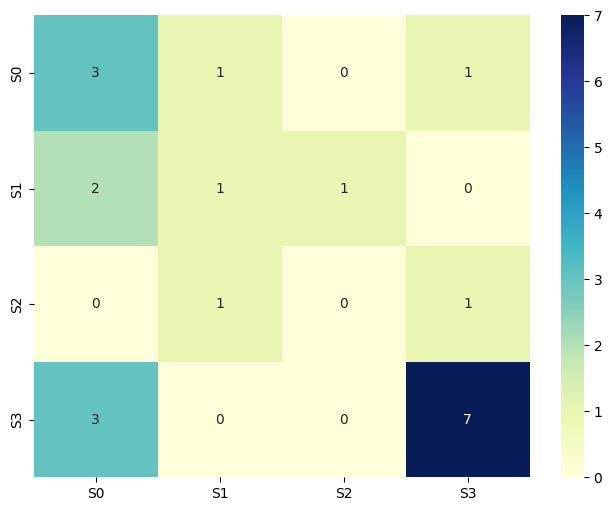

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

# --- 1. CONFIGURATION ---
DATA_PATH = '/kaggle/input/extracted-scans-categorizes0-s1-s2-s3/extracted_scans'
CLASSES = ['S0', 'S1', 'S2', 'S3']
MAX_SEQ_LENGTH = 8   
BATCH_SIZE = 4       # Reduced batch size for 384x384 to save GPU memory
EPOCHS = 100         
PATIENCE = 20        
FOLDS = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. DATASET CLASS ---
class PancreasDataset(Dataset):
    def __init__(self, paths, labels, transform=None, is_train=True):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        self.is_train = is_train

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        label = self.labels[idx]
        img_names = sorted([f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        
        if self.is_train and len(img_names) > MAX_SEQ_LENGTH:
            selected = sorted(random.sample(img_names, MAX_SEQ_LENGTH))
        elif len(img_names) > MAX_SEQ_LENGTH:
            indices = np.linspace(0, len(img_names)-1, MAX_SEQ_LENGTH, dtype=int)
            selected = [img_names[i] for i in indices]
        else:
            selected = img_names

        sequence = []
        for name in selected:
            img = Image.open(os.path.join(path, name)).convert('RGB')
            if self.transform: img = self.transform(img)
            sequence.append(img)
            
        while len(sequence) < MAX_SEQ_LENGTH:
            padding = torch.zeros_like(sequence[0]) if sequence else torch.zeros(3, 384, 384)
            sequence.append(padding)
            
        return torch.stack(sequence), label

# --- 3. MODEL ARCHITECTURE ---
class PancreasTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = models.efficientnet_b0(weights='IMAGENET1K_V1')
        
        # Freeze early layers, keep final stages trainable
        for param in backbone.parameters():
            param.requires_grad = False
        for name, param in backbone.named_parameters():
            if "blocks.6" in name or "blocks.7" in name or "features.8" in name:
                param.requires_grad = True
                
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-1])
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=1280, nhead=4, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)
        
        self.classifier = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 4)
        )

    def forward(self, x):
        batch, seq, c, h, w = x.shape
        x = x.view(batch * seq, c, h, w)
        features = self.feature_extractor(x).view(batch, seq, -1)
        x = self.transformer(features)
        x = torch.mean(x, dim=1) 
        return self.classifier(x)

# --- 4. PREPARATION & TRANSFORMS (384x384) ---
all_paths, all_labels = [], []
for i, cls in enumerate(CLASSES):
    cls_dir = os.path.join(DATA_PATH, cls)
    if os.path.exists(cls_dir):
        for p_folder in os.listdir(cls_dir):
            all_paths.append(os.path.join(cls_dir, p_folder))
            all_labels.append(i)

all_paths = np.array(all_paths)
all_labels = np.array(all_labels)

train_tfms = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# --- 5. K-FOLD TRAINING WITH COSINE ANNEALING ---
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(all_paths, all_labels)):
    print(f"\n--- FOLD {fold+1} (384px + Cosine Annealing) ---")
    
    train_loader = DataLoader(PancreasDataset(all_paths[train_idx], all_labels[train_idx], train_tfms), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(PancreasDataset(all_paths[val_idx], all_labels[val_idx], val_tfms, False), batch_size=BATCH_SIZE)
    
    model = PancreasTransformer().to(DEVICE)
    class_weights = torch.tensor([1.8, 2.5, 3.0, 1.0]).to(DEVICE)
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.15)
    
    # Using AdamW for better weight decay with Cosine Annealing
    optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
    
    # Cosine Annealing with Warm Restarts
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-7)
    
    best_loss = float('inf')
    no_improve = 0
    
    for epoch in range(EPOCHS):
        model.train()
        t_loss = 0
        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model(imgs), lbls)
            loss.backward()
            optimizer.step()
            t_loss += loss.item()
        
        model.eval()
        v_loss = 0
        with torch.no_grad():
            for imgs, lbls in val_loader:
                v_loss += criterion(model(imgs.to(DEVICE)), lbls.to(DEVICE)).item()
        
        avg_v_loss = v_loss / len(val_loader)
        scheduler.step() # Step every epoch for cosine annealing
        
        if avg_v_loss < best_loss:
            best_loss = avg_v_loss
            torch.save(model.state_dict(), f'best_model_fold_{fold+1}.pth')
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= PATIENCE: break

# --- 6. FINAL ENSEMBLE EVALUATION WITH TTA ---
def final_tta_evaluate(val_idx):
    test_loader = DataLoader(PancreasDataset(all_paths[val_idx], all_labels[val_idx], val_tfms, False), batch_size=1)
    tta_transforms = [
        lambda x: x,
        lambda x: torch.flip(x, dims=[-1]),
        lambda x: torch.rot90(x, 1, [-2, -1]),
        lambda x: torch.flip(x, dims=[-2])
    ]

    all_true = []
    final_probs = []

    for imgs, lbls in test_loader:
        all_true.append(lbls.item())
        patient_probs = []
        for fold in range(1, FOLDS + 1):
            m = PancreasTransformer().to(DEVICE)
            m.load_state_dict(torch.load(f'best_model_fold_{fold}.pth'))
            m.eval()
            with torch.no_grad():
                tta_fold_probs = []
                for t in tta_transforms:
                    aug_imgs = t(imgs.to(DEVICE))
                    tta_fold_probs.append(torch.softmax(m(aug_imgs), dim=1).cpu().numpy())
                patient_probs.append(np.mean(tta_fold_probs, axis=0))
        final_probs.append(np.mean(patient_probs, axis=0).squeeze())

    final_preds = np.argmax(final_probs, axis=1)
    print("\n--- Final Performance (384px + TTA) ---")
    print(classification_report(all_true, final_preds, target_names=CLASSES, zero_division=0))
    
    cm = confusion_matrix(all_true, final_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, xticklabels=CLASSES, yticklabels=CLASSES, cmap='YlGnBu')
    plt.show()

final_tta_evaluate(val_idx)


--- FOLD 1 (B3 + Optimized Hyperparams) ---
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:00<00:00, 176MB/s] 



--- FOLD 2 (B3 + Optimized Hyperparams) ---

--- FOLD 3 (B3 + Optimized Hyperparams) ---

--- FOLD 4 (B3 + Optimized Hyperparams) ---

--- FOLD 5 (B3 + Optimized Hyperparams) ---

--- Final Performance Report ---
              precision    recall  f1-score   support

          S0       0.00      0.00      0.00         5
          S1       0.50      0.50      0.50         4
          S2       0.10      0.50      0.17         2
          S3       0.86      0.60      0.71        10

    accuracy                           0.43        21
   macro avg       0.36      0.40      0.34        21
weighted avg       0.51      0.43      0.45        21



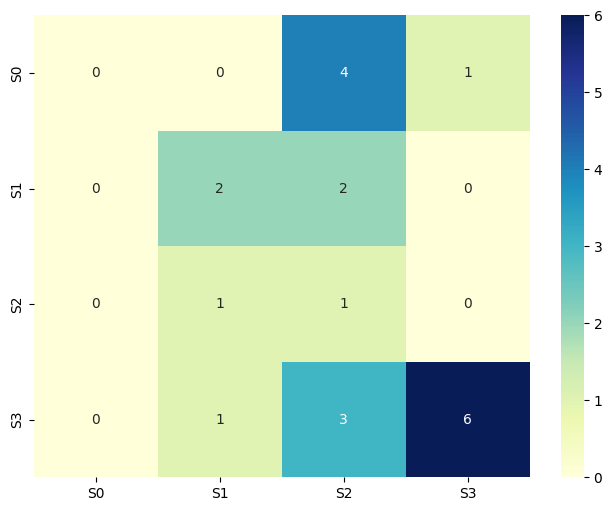

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

# --- 1. CONFIGURATION ---
DATA_PATH = '/kaggle/input/extracted-scans-categorizes0-s1-s2-s3/extracted_scans'
CLASSES = ['S0', 'S1', 'S2', 'S3']
MAX_SEQ_LENGTH = 8   
BATCH_SIZE = 4       # EfficientNet-B3 is heavier; keep batch size small
EPOCHS = 100         
PATIENCE = 25        # Increased patience for more stable convergence
FOLDS = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. DATASET CLASS ---
class PancreasDataset(Dataset):
    def __init__(self, paths, labels, transform=None, is_train=True):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        self.is_train = is_train

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        label = self.labels[idx]
        img_names = sorted([f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        
        if self.is_train and len(img_names) > MAX_SEQ_LENGTH:
            selected = sorted(random.sample(img_names, MAX_SEQ_LENGTH))
        elif len(img_names) > MAX_SEQ_LENGTH:
            indices = np.linspace(0, len(img_names)-1, MAX_SEQ_LENGTH, dtype=int)
            selected = [img_names[i] for i in indices]
        else:
            selected = img_names

        sequence = []
        for name in selected:
            img = Image.open(os.path.join(path, name)).convert('RGB')
            if self.transform: img = self.transform(img)
            sequence.append(img)
            
        while len(sequence) < MAX_SEQ_LENGTH:
            # Match 384x384 resolution
            padding = torch.zeros_like(sequence[0]) if sequence else torch.zeros(3, 384, 384)
            sequence.append(padding)
            
        return torch.stack(sequence), label

# --- 3. MODEL ARCHITECTURE (Upgraded to B3) ---
class PancreasTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        # Upgraded to B3 for better resolution utilization
        backbone = models.efficientnet_b3(weights='IMAGENET1K_V1')
        
        # Partially unfreeze the last stages
        for param in backbone.parameters():
            param.requires_grad = False
        for name, param in backbone.named_parameters():
            if "blocks.6" in name or "blocks.7" in name or "features.8" in name:
                param.requires_grad = True
                
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-1])
        
        # d_model for B3 is 1536 (B0 was 1280)
        encoder_layer = nn.TransformerEncoderLayer(d_model=1536, nhead=4, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)
        
        self.classifier = nn.Sequential(
            nn.Linear(1536, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 4)
        )

    def forward(self, x):
        batch, seq, c, h, w = x.shape
        x = x.view(batch * seq, c, h, w)
        features = self.feature_extractor(x).view(batch, seq, -1)
        x = self.transformer(features)
        x = torch.mean(x, dim=1) 
        return self.classifier(x)

# --- 4. PREPARATION & TRANSFORMS ---
all_paths, all_labels = [], []
for i, cls in enumerate(CLASSES):
    cls_dir = os.path.join(DATA_PATH, cls)
    if os.path.exists(cls_dir):
        for p_folder in os.listdir(cls_dir):
            all_paths.append(os.path.join(cls_dir, p_folder))
            all_labels.append(i)

all_paths = np.array(all_paths)
all_labels = np.array(all_labels)

train_tfms = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# --- 5. K-FOLD TRAINING WITH AGGRESSIVE WEIGHTS ---
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(all_paths, all_labels)):
    print(f"\n--- FOLD {fold+1} (B3 + Optimized Hyperparams) ---")
    
    train_loader = DataLoader(PancreasDataset(all_paths[train_idx], all_labels[train_idx], train_tfms), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(PancreasDataset(all_paths[val_idx], all_labels[val_idx], val_tfms, False), batch_size=BATCH_SIZE)
    
    model = PancreasTransformer().to(DEVICE)
    
    # Aggressive S2 weighting (8.0) to force the model to recognize the stage
    class_weights = torch.tensor([1.5, 3.0, 8.0, 1.0]).to(DEVICE)
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
    
    optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
    
    # Increased T_0 for longer, more stable cycles
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=25, T_mult=1, eta_min=1e-7)
    
    best_loss = float('inf')
    no_improve = 0
    
    for epoch in range(EPOCHS):
        model.train()
        t_loss = 0
        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model(imgs), lbls)
            loss.backward()
            optimizer.step()
            t_loss += loss.item()
        
        model.eval()
        v_loss = 0
        with torch.no_grad():
            for imgs, lbls in val_loader:
                v_loss += criterion(model(imgs.to(DEVICE)), lbls.to(DEVICE)).item()
        
        avg_v_loss = v_loss / len(val_loader)
        scheduler.step()
        
        if avg_v_loss < best_loss:
            best_loss = avg_v_loss
            torch.save(model.state_dict(), f'best_model_fold_{fold+1}.pth')
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= PATIENCE: break

# --- 6. FINAL ENSEMBLE EVALUATION WITH TTA ---
def final_tta_evaluate(val_idx):
    test_loader = DataLoader(PancreasDataset(all_paths[val_idx], all_labels[val_idx], val_tfms, False), batch_size=1)
    tta_transforms = [
        lambda x: x,
        lambda x: torch.flip(x, dims=[-1]),
        lambda x: torch.rot90(x, 1, [-2, -1]),
        lambda x: torch.flip(x, dims=[-2])
    ]

    all_true = []
    final_probs = []

    for imgs, lbls in test_loader:
        all_true.append(lbls.item())
        patient_probs = []
        for fold in range(1, FOLDS + 1):
            m = PancreasTransformer().to(DEVICE)
            m.load_state_dict(torch.load(f'best_model_fold_{fold}.pth'))
            m.eval()
            with torch.no_grad():
                tta_fold_probs = []
                for t in tta_transforms:
                    aug_imgs = t(imgs.to(DEVICE))
                    tta_fold_probs.append(torch.softmax(m(aug_imgs), dim=1).cpu().numpy())
                patient_probs.append(np.mean(tta_fold_probs, axis=0))
        final_probs.append(np.mean(patient_probs, axis=0).squeeze())

    final_preds = np.argmax(final_probs, axis=1)
    print("\n--- Final Performance Report ---")
    print(classification_report(all_true, final_preds, target_names=CLASSES, zero_division=0))
    
    cm = confusion_matrix(all_true, final_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, xticklabels=CLASSES, yticklabels=CLASSES, cmap='YlGnBu')
    plt.show()

final_tta_evaluate(val_idx)

In [4]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

# --- 1. CONFIGURATION ---
DATA_PATH = '/kaggle/input/extracted-scans-categorizes0-s1-s2-s3/extracted_scans'
CLASSES = ['S0', 'S1', 'S2', 'S3']
MAX_SEQ_LENGTH = 8   
BATCH_SIZE = 8       # Increased for more stable gradients
EPOCHS = 100         
PATIENCE = 20        
FOLDS = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. DATASET CLASS ---
class PancreasDataset(Dataset):
    def __init__(self, paths, labels, transform=None, is_train=True):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        self.is_train = is_train

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        label = self.labels[idx]
        img_names = sorted([f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        
        if self.is_train and len(img_names) > MAX_SEQ_LENGTH:
            selected = sorted(random.sample(img_names, MAX_SEQ_LENGTH))
        elif len(img_names) > MAX_SEQ_LENGTH:
            indices = np.linspace(0, len(img_names)-1, MAX_SEQ_LENGTH, dtype=int)
            selected = [img_names[i] for i in indices]
        else:
            selected = img_names

        sequence = []
        for name in selected:
            img = Image.open(os.path.join(path, name)).convert('RGB')
            if self.transform: img = self.transform(img)
            sequence.append(img)
            
        while len(sequence) < MAX_SEQ_LENGTH:
            # Standardizing to 224x224 for B2 efficiency
            padding = torch.zeros_like(sequence[0]) if sequence else torch.zeros(3, 224, 224)
            sequence.append(padding)
            
        return torch.stack(sequence), label

# --- 3. MODEL ARCHITECTURE (EfficientNet-B2 + Transformer) ---
class PancreasTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        # Upgraded to B2 for a better balance of capacity and speed
        backbone = models.efficientnet_b2(weights='IMAGENET1K_V1')
        
        # Partially unfreeze the last layers for task-specific feature extraction
        for param in backbone.parameters():
            param.requires_grad = False
        for name, param in backbone.named_parameters():
            if "blocks.6" in name or "features.8" in name:
                param.requires_grad = True
                
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-1])
        
        # d_model for B2 is 1408
        encoder_layer = nn.TransformerEncoderLayer(d_model=1408, nhead=4, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)
        
        self.classifier = nn.Sequential(
            nn.Linear(1408, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 4)
        )

    def forward(self, x):
        batch, seq, c, h, w = x.shape
        x = x.view(batch * seq, c, h, w)
        features = self.feature_extractor(x).view(batch, seq, -1)
        x = self.transformer(features)
        x = torch.mean(x, dim=1) 
        return self.classifier(x)

# --- 4. PREPARATION ---
all_paths, all_labels = [], []
for i, cls in enumerate(CLASSES):
    cls_dir = os.path.join(DATA_PATH, cls)
    if os.path.exists(cls_dir):
        for p_folder in os.listdir(cls_dir):
            all_paths.append(os.path.join(cls_dir, p_folder))
            all_labels.append(i)

all_paths = np.array(all_paths)
all_labels = np.array(all_labels)

# Balanced transforms
train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# --- 5. K-FOLD TRAINING ---
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(all_paths, all_labels)):
    print(f"\n--- STARTING FOLD {fold+1} ---")
    
    train_loader = DataLoader(PancreasDataset(all_paths[train_idx], all_labels[train_idx], train_tfms), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(PancreasDataset(all_paths[val_idx], all_labels[val_idx], val_tfms, False), batch_size=BATCH_SIZE)
    
    model = PancreasTransformer().to(DEVICE)
    
    # NEW WEIGHTS: Balanced to prevent S0 collapse while still helping S2
    # [S0: 2.5, S1: 3.5, S2: 5.0, S3: 1.0]
    class_weights = torch.tensor([2.5, 3.5, 5.0, 1.0]).to(DEVICE)
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)
    
    optimizer = optim.AdamW(model.parameters(), lr=8e-6, weight_decay=0.01)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=1)
    
    best_loss = float('inf')
    no_improve = 0
    
    for epoch in range(EPOCHS):
        model.train()
        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model(imgs), lbls)
            loss.backward()
            optimizer.step()
        
        model.eval()
        v_loss = 0
        with torch.no_grad():
            for imgs, lbls in val_loader:
                v_loss += criterion(model(imgs.to(DEVICE)), lbls.to(DEVICE)).item()
        
        avg_v_loss = v_loss / len(val_loader)
        scheduler.step()
        
        if avg_v_loss < best_loss:
            best_loss = avg_v_loss
            torch.save(model.state_dict(), f'fold_{fold+1}_best.pth')
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= PATIENCE: break

# --- 6. ENSEMBLE EVALUATION ---
def evaluate_ensemble(val_idx):
    test_loader = DataLoader(PancreasDataset(all_paths[val_idx], all_labels[val_idx], val_tfms, False), batch_size=1)
    all_true, all_probs = [], []

    for imgs, lbls in test_loader:
        all_true.append(lbls.item())
        fold_probs = []
        for fold in range(1, FOLDS + 1):
            m = PancreasTransformer().to(DEVICE)
            m.load_state_dict(torch.load(f'fold_{fold}_best.pth'))
            m.eval()
            with torch.no_grad():
                fold_probs.append(torch.softmax(m(imgs.to(DEVICE)), dim=1).cpu().numpy())
        all_probs.append(np.mean(fold_probs, axis=0).flatten())

    preds = np.argmax(all_probs, axis=1)
    print("\n--- Balanced Ensemble Results ---")
    print(classification_report(all_true, preds, target_names=CLASSES, zero_division=0))

evaluate_ensemble(val_idx)


--- STARTING FOLD 1 ---
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth


100%|██████████| 35.2M/35.2M [00:00<00:00, 169MB/s] 



--- STARTING FOLD 2 ---

--- STARTING FOLD 3 ---

--- STARTING FOLD 4 ---

--- STARTING FOLD 5 ---

--- Balanced Ensemble Results ---
              precision    recall  f1-score   support

          S0       0.67      0.40      0.50         5
          S1       0.38      0.75      0.50         4
          S2       0.17      0.50      0.25         2
          S3       0.75      0.30      0.43        10

    accuracy                           0.43        21
   macro avg       0.49      0.49      0.42        21
weighted avg       0.60      0.43      0.44        21

